In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from pyrl.agents.classic import QLearning as ClassicQLearning
from pyrl.agents.survival import QLearning as SurvivalQLearning
from pyrl.agents.survival import KLearning
from pyrl.environments.survival import SurvivalEnv
from pyrl import Sim, Agent, Env, EnvWrapper, System

from gymnasium.spaces import Discrete, MultiDiscrete

In [5]:
e = EnvWrapper(gym.make('CartPole-v1', render_mode='human'))
a = Agent(e.observation_space, e.action_space)
s = System(env=e, agent=a)

s.reset()

for i in range(200):
    state, observation, action, reward, terminated, truncated, info = s.step()
    if terminated or truncated:
        s.reset()

e.close()


## Test with rendering

In the next cell, we call a single simulation with visual rendering.

Use `skip_visual_test` to enable or disable it.

In [6]:
from pyrl.environments.grid import GridEnv, GridEnvRender

num_rows=5
num_cols=30

minor_r = 5.0
major_r = 100.0

#env = GridEnv(num_cols=3, num_rows=4, reward_matrix=[[-1,-1,5,-1],[0,0,0,0],[-1,-1,-1,100]], reward_mode="s'", render_mode="external")
#env = GridEnv(num_rows=num_rows, num_cols=num_cols, reward_mode="s'", render_mode="external")

reward_targets = {major_r : [(num_cols - 2, num_rows // 2)],
                  minor_r : [(3*(num_cols - 1) // 5, num_rows // 2), ((num_cols - 1) // 3, num_rows // 2)]}

env = GridEnv(num_rows=num_rows, num_cols=num_cols, 
              reward_mode="s'", reward_targets=reward_targets, default_reward=-1.0,
              render_mode="external")

horizon = 2000

initial_Q_value = 0
gamma = 0.95 #discount factor
alpha = 0.5 #learning rate
epsilon=0.5 #exploration rate
initial_budget = 500

agent = Agent(observation_space = env.observation_space, action_space = env.action_space, initial_budget=initial_budget)

env.agent = agent

try:
    window = GridEnvRender(env, agent, cell_size=30)
except:
    window.close()
    raise

env._render_frame = window._render_frame

def simulation_started_callback(sim, env, agent):
    print("START SIM")
    print(env.observation_shape)
    print(env.action_shape)
    print(env.observation_shape + env.action_shape)
    sim.metrics = dict(
        time = 0,
        exploration = np.zeros(env.observation_shape + env.action_shape),
        budget = np.zeros((sim.episode_horizon,), dtype=int)
    )

def simulation_finished_callback(sim, env, agent):
    print("END SIM")

def episode_started_callback(sim, env, agent):
    print("START EPISODE")

def episode_finished_callback(sim, env, agent):
    print("END EPISODE")
    #pass

def round_started_callback(sim, env, agent):
    #print("START ROUND")
    pass

def round_finished_callback(sim, env, agent):
    #print("END ROUND")
    sim.metrics["time"] = sim.metrics["time"] + 1
    state_action_index = tuple(np.concatenate( (agent.get_state(), agent.get_action()) ) )
    v = sim.metrics["exploration"].item(state_action_index)
    sim.metrics["exploration"].itemset(state_action_index, v+1)
    sim.metrics["budget"][sim.t-1] = agent.budget        
        
sim = Sim(agent, env, episode_horizon=horizon,
         simulation_started_callback=simulation_started_callback,
         simulation_finished_callback=simulation_finished_callback,
         episode_started_callback=episode_started_callback,
         episode_finished_callback=episode_finished_callback,
         round_started_callback=round_started_callback,
         round_finished_callback=round_finished_callback
         )

try:
    sim.run()
except:
    window.close()
    raise

window.close()


START SIM
(30, 5)
(4,)
(30, 5, 4)
START EPISODE
END EPISODE
END SIM


In [8]:
skip_visual_test = False

if skip_visual_test:
    
    print("Skipping visual test")
    
else:

    map_size = (30, 5)
    minor_r=5
    major_r=50
    step_r=-1
    horizon = 2000
    initial_Q_value = 0
    initial_K_value = 200
    survival_threshold = 250
    exploration_threshold = 500
    gamma = 0.95 #discount factor
    alpha = 0.5 #learning rate
    epsilon=0.5 #exploration rate
    initial_budget = 500

    #env = gym.make("pyrl.environments:Survival-v0", size=map_size, render_mode="human", minor_r=minor_r, major_r=major_r, step_r=step_r)
    #env = SurvivalEnv(size=map_size, minor_r=minor_r, major_r=major_r, step_r=step_r, render_mode="human")


    agent_K = KLearning(
        env.observation_space,
        env.action_space,
        budget=initial_budget,
        should_explore=None,
        discount=gamma,
        learning_rate=alpha,
        initial_Q_value=initial_Q_value,
        initial_K_value=initial_K_value,
        survival_threshold=survival_threshold,
        exploration_threshold=exploration_threshold,
    )

    agent_Q = ClassicQLearning(env.observation_space, 
                             env.action_space, 
                             budget=initial_budget, 
                             discount=gamma,
                             learning_rate=alpha,
                             exploration_rate=epsilon,
                             initial_Q_value=initial_Q_value)

    env.agent = agent_Q

    sim = Sim([agent_Q, agent_K], env, episode_horizon=horizon, 
              episode_finished_callback=episode_callback, 
              simulation_finished_callback=simulation_callback,
              round_finished_callback=step_callback
             )
    
    
    try:
        sim.run()
    except:
        env.close()
        raise
    
    env.close()

    

AttributeError: 'MultiDiscrete' object has no attribute 'n'

## Massive Tests

In [9]:
map_size = (50, 5)
minor_r=5
major_r=50 
step_r=-1
horizon = 5000
initial_Q_value = 0
initial_K_value = 200
survival_threshold = 400
exploration_threshold = 800
gamma = 0.95 #discount factor
alpha = 0.5 #learning rate
epsilon = 0.1 #exploration rate
repeat = 50
budgets = np.array([100, 200, 300, 400, 500, 600, 700, 800])

env = gym.make("pyrl.environments:Survival-v0", size=map_size, minor_r=minor_r, major_r=major_r, step_r=step_r)
#env = SurvivalEnv(size=map_size, minor_r=minor_r, major_r=major_r, step_r=step_r)

print(env.minor_r)


5.7


## Classic QLearning $\varepsilon = 0.1$

In [5]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.1

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_1_time_mean = qclassic_time_mean
qclassic_1_exploration_rate = qclassic_exploration_rate
qclassic_1_alive_rate = qclassic_alive_rate
qclassic_1_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_1_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_1_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_1_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 200
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 884
Alive rate : 12%
b=400 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 2013
Alive rate : 34%
b=500 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Time mean : 3436
Alive rate : 66%
b=600 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25

KeyboardInterrupt: 

## Classic QLearning $\varepsilon = 0.3$

In [28]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.3

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_3_time_mean = qclassic_time_mean
qclassic_3_exploration_rate = qclassic_exploration_rate
qclassic_3_alive_rate = qclassic_alive_rate
qclassic_3_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_3_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_3_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_3_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 
Time mean : 200
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 
Time mean : 882
Alive rate : 10%
b=400 1 2 3 4 5 6 7 8 9 10 
Time mean : 1440
Alive rate : 20%
b=500 1 2 3 4 5 6 7 8 9 10 
Time mean : 1066
Alive rate : 20%
b=600 1 2 3 4 5 6 7 8 9 10 
Time mean : 1112
Alive rate : 20%
b=700 1 2 3 4 5 6 7 8 9 10 
Time mean : 3598
Alive rate : 60%
b=800 1 2 3 4 5 6 7 8 9 10 
Time mean : 4534
Alive rate : 90%


## Classic QLearning $\varepsilon = 0.5$

In [29]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.3

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_5_time_mean = qclassic_time_mean
qclassic_5_exploration_rate = qclassic_exploration_rate
qclassic_5_alive_rate = qclassic_alive_rate
qclassic_5_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_5_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_5_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_5_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 
Time mean : 200
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 
Time mean : 343
Alive rate : 0%
b=400 1 2 3 4 5 6 7 8 9 10 
Time mean : 993
Alive rate : 20%
b=500 1 2 3 4 5 6 7 8 9 10 
Time mean : 2012
Alive rate : 40%
b=600 1 2 3 4 5 6 7 8 9 10 
Time mean : 2712
Alive rate : 40%
b=700 1 2 3 4 5 6 7 8 9 10 
Time mean : 4047
Alive rate : 80%
b=800 1 2 3 4 5 6 7 8 9 10 
Time mean : 2256
Alive rate : 40%


## Classic QLearning greedy

In [30]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.0

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_Q_value)
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_0_time_mean = qclassic_time_mean
qclassic_0_exploration_rate = qclassic_exploration_rate
qclassic_0_alive_rate = qclassic_alive_rate
qclassic_0_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_0_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_0_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_0_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 
Time mean : 200
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 
Time mean : 1865
Alive rate : 30%
b=400 1 2 3 4 5 6 7 8 9 10 
Time mean : 2953
Alive rate : 50%
b=500 1 2 3 4 5 6 7 8 9 10 
Time mean : 2499
Alive rate : 40%
b=600 1 2 3 4 5 6 7 8 9 10 
Time mean : 4021
Alive rate : 80%
b=700 1 2 3 4 5 6 7 8 9 10 
Time mean : 5000
Alive rate : 100%
b=800 1 2 3 4 5 6 7 8 9 10 
Time mean : 5000
Alive rate : 100%


## Classic Q-Learning optimistic

In [31]:
qclassic_time_mean = np.full(budgets.shape, -1)
qclassic_exploration_rate = np.full(budgets.shape, -1)
qclassic_alive_rate = np.full(budgets.shape, -1)
qclassic_budget_evolutions_mean = np.full(budgets.shape, None)
qclassic_budget_evolutions_max = np.full(budgets.shape, None)
qclassic_budget_evolutions_min = np.full(budgets.shape, None)
qclassic_exploration_map = np.full(budgets.shape, None)

epsilon=0.0

print("====> Classic QLearning")

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        agent = ClassicQLearning(env.observation_space, 
                                 env.action_space, 
                                 budget=b, 
                                 discount=gamma,
                                 learning_rate=alpha,
                                 exploration_rate=epsilon,
                                 initial_Q_value=initial_K_value)
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qclassic_time_mean[i] == -1:
            qclassic_time_mean[i] = sim.metrics["time"]
        else:
            qclassic_time_mean[i] = qclassic_time_mean[i] + (1/j) * (sim.metrics["time"] - qclassic_time_mean[i])
        
        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qclassic_exploration_rate[i] == -1:
            qclassic_exploration_rate[i] = exploration_rate
        else:
            qclassic_exploration_rate[i] = qclassic_exploration_rate[i] + (1 / j) * (exploration_rate - qclassic_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qclassic_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qclassic_budget_evolutions_mean[i] is None:
            qclassic_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_mean[i] = qclassic_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qclassic_budget_evolutions_mean[i])

        # budget evolution max
        if qclassic_budget_evolutions_max[i] is None:
            qclassic_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_max[i] = np.maximum(qclassic_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qclassic_budget_evolutions_min[i] is None:
            qclassic_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qclassic_budget_evolutions_min[i] = np.minimum(qclassic_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qclassic_exploration_map[i] is None:
            qclassic_exploration_map[i] = sim.metrics["exploration"]
        else:
            qclassic_exploration_map[i] = qclassic_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qclassic_exploration_map[i])

    print()
    print(f"Time mean : {qclassic_time_mean[i]}")
    print(f"Alive rate : {qclassic_alive_rate[i]}%")


qclassic_h_time_mean = qclassic_time_mean
qclassic_h_exploration_rate = qclassic_exploration_rate
qclassic_h_alive_rate = qclassic_alive_rate
qclassic_h_budget_evolutions_mean = qclassic_budget_evolutions_mean
qclassic_h_budget_evolutions_max = qclassic_budget_evolutions_max
qclassic_h_budget_evolutions_min = qclassic_budget_evolutions_min
qclassic_h_exploration_map = qclassic_exploration_map

====> Classic QLearning
b=100 1 2 3 4 5 6 7 8 9 10 
Time mean : 100
Alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 
Time mean : 200
Alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 
Time mean : 302
Alive rate : 0%
b=400 1 2 3 4 5 6 7 8 9 10 
Time mean : 404
Alive rate : 0%
b=500 1 2 3 4 5 6 7 8 9 10 
Time mean : 527
Alive rate : 0%
b=600 1 2 3 4 5 6 7 8 9 10 
Time mean : 628
Alive rate : 0%
b=700 1 2 3 4 5 6 7 8 9 10 
Time mean : 742
Alive rate : 0%
b=800 1 2 3 4 5 6 7 8 9 10 
Time mean : 850
Alive rate : 0%


## Survival QLearning $w = \{250 - 500\}$

In [32]:
qsurvival_time_mean = np.full(budgets.shape, -1)
qsurvival_exploration_rate = np.full(budgets.shape, -1)
qsurvival_alive_rate = np.full(budgets.shape, -1)
qsurvival_budget_evolutions_mean = np.full(budgets.shape, None)
qsurvival_budget_evolutions_max = np.full(budgets.shape, None)
qsurvival_budget_evolutions_min = np.full(budgets.shape, None)
qsurvival_exploration_map = np.full(budgets.shape, None)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = KLearning(
            env.observation_space,
            env.action_space,
            budget=b,
            discount=gamma,
            learning_rate=alpha,
            initial_Q_value=initial_Q_value,
            initial_K_value=initial_K_value,
            survival_threshold=250,
            exploration_threshold=500,
        )
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qsurvival_time_mean[i] == -1:
            qsurvival_time_mean[i] = sim.metrics["time"]
        else:
            qsurvival_time_mean[i] = qsurvival_time_mean[i] + (1/j) * (sim.metrics["time"] - qsurvival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qsurvival_exploration_rate[i] == -1:
            qsurvival_exploration_rate[i] = exploration_rate
        else:
            qsurvival_exploration_rate[i] = qsurvival_exploration_rate[i] + (1 / j) * (exploration_rate - qsurvival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qsurvival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qsurvival_budget_evolutions_mean[i] is None:
            qsurvival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_mean[i] = qsurvival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qsurvival_budget_evolutions_mean[i])

        # budget evolution max
        if qsurvival_budget_evolutions_max[i] is None:
            qsurvival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_max[i] = np.maximum(qsurvival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qsurvival_budget_evolutions_min[i] is None:
            qsurvival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_min[i] = np.minimum(qsurvival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qsurvival_exploration_map[i] is None:
            qsurvival_exploration_map[i] = sim.metrics["exploration"]
        else:
            qsurvival_exploration_map[i] = qsurvival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qsurvival_exploration_map[i])

        #print(f"Time mean : {qsurvival_time_mean[i]}")
        #print(f"Alive rate : {qsurvival_alive_rate[i]}%")
        
    print()
    print(f"* average survival time : {qsurvival_time_mean[i]}")
    print(f"* alive rate : {qsurvival_alive_rate[i]}%")
    
qsurvival_250_time_mean = qsurvival_time_mean
qsurvival_250_exploration_rate = qsurvival_exploration_rate
qsurvival_250_alive_rate = qsurvival_alive_rate
qsurvival_250_budget_evolutions_mean = qsurvival_budget_evolutions_mean
qsurvival_250_budget_evolutions_max = qsurvival_budget_evolutions_max
qsurvival_250_budget_evolutions_min = qsurvival_budget_evolutions_min
qsurvival_250_exploration_map = qsurvival_exploration_map
        

b=100 1 2 3 4 5 6 7 8 9 10 
* average survival time : 100
* alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 
* average survival time : 200
* alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 
* average survival time : 1342
* alive rate : 20%
b=400 1 2 3 4 5 6 7 8 9 10 
* average survival time : 2953
* alive rate : 60%
b=500 1 2 3 4 5 6 7 8 9 10 
* average survival time : 3298
* alive rate : 50%
b=600 1 2 3 4 5 6 7 8 9 10 
* average survival time : 2907
* alive rate : 40%
b=700 1 2 3 4 5 6 7 8 9 10 
* average survival time : 3671
* alive rate : 70%
b=800 1 2 3 4 5 6 7 8 9 10 
* average survival time : 4276
* alive rate : 80%


## Survival QLearning $w = \{400, 800\}$

In [33]:
qsurvival_time_mean = np.full(budgets.shape, -1)
qsurvival_exploration_rate = np.full(budgets.shape, -1)
qsurvival_alive_rate = np.full(budgets.shape, -1)
qsurvival_budget_evolutions_mean = np.full(budgets.shape, None)
qsurvival_budget_evolutions_max = np.full(budgets.shape, None)
qsurvival_budget_evolutions_min = np.full(budgets.shape, None)
qsurvival_exploration_map = np.full(budgets.shape, None)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = KLearning(
            env.observation_space,
            env.action_space,
            budget=b,
            discount=gamma,
            learning_rate=alpha,
            initial_Q_value=initial_Q_value,
            initial_K_value=initial_K_value,
            survival_threshold=400,
            exploration_threshold=800,
        )
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qsurvival_time_mean[i] == -1:
            qsurvival_time_mean[i] = sim.metrics["time"]
        else:
            qsurvival_time_mean[i] = qsurvival_time_mean[i] + (1/j) * (sim.metrics["time"] - qsurvival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qsurvival_exploration_rate[i] == -1:
            qsurvival_exploration_rate[i] = exploration_rate
        else:
            qsurvival_exploration_rate[i] = qsurvival_exploration_rate[i] + (1 / j) * (exploration_rate - qsurvival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qsurvival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qsurvival_budget_evolutions_mean[i] is None:
            qsurvival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_mean[i] = qsurvival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qsurvival_budget_evolutions_mean[i])

        # budget evolution max
        if qsurvival_budget_evolutions_max[i] is None:
            qsurvival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_max[i] = np.maximum(qsurvival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qsurvival_budget_evolutions_min[i] is None:
            qsurvival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_min[i] = np.minimum(qsurvival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qsurvival_exploration_map[i] is None:
            qsurvival_exploration_map[i] = sim.metrics["exploration"]
        else:
            qsurvival_exploration_map[i] = qsurvival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qsurvival_exploration_map[i])

        #print(f"Time mean : {qsurvival_time_mean[i]}")
        #print(f"Alive rate : {qsurvival_alive_rate[i]}%")
        
    print()
    print(f"* average survival time : {qsurvival_time_mean[i]}")
    print(f"* alive rate : {qsurvival_alive_rate[i]}%")
    
qsurvival_400_time_mean = qsurvival_time_mean
qsurvival_400_exploration_rate = qsurvival_exploration_rate
qsurvival_400_alive_rate = qsurvival_alive_rate
qsurvival_400_budget_evolutions_mean = qsurvival_budget_evolutions_mean
qsurvival_400_budget_evolutions_max = qsurvival_budget_evolutions_max
qsurvival_400_budget_evolutions_min = qsurvival_budget_evolutions_min
qsurvival_400_exploration_map = qsurvival_exploration_map

b=100 1 2 3 4 5 6 7 8 9 10 
* average survival time : 100
* alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 
* average survival time : 200
* alive rate : 0%
b=300 1 2 3 4 5 6 7 8 9 10 
* average survival time : 479
* alive rate : 10%
b=400 1 2 3 4 5 6 7 8 9 10 
* average survival time : 911
* alive rate : 20%
b=500 1 2 3 4 5 6 7 8 9 10 
* average survival time : 3500
* alive rate : 70%
b=600 1 2 3 4 5 6 7 8 9 10 
* average survival time : 4022
* alive rate : 80%
b=700 1 2 3 4 5 6 7 8 9 10 
* average survival time : 5000
* alive rate : 100%
b=800 1 2 3 4 5 6 7 8 9 10 
* average survival time : 5000
* alive rate : 100%


## Survival QLearning $w=\{600 - 1000\}

In [34]:
qsurvival_time_mean = np.full(budgets.shape, -1)
qsurvival_exploration_rate = np.full(budgets.shape, -1)
qsurvival_alive_rate = np.full(budgets.shape, -1)
qsurvival_budget_evolutions_mean = np.full(budgets.shape, None)
qsurvival_budget_evolutions_max = np.full(budgets.shape, None)
qsurvival_budget_evolutions_min = np.full(budgets.shape, None)
qsurvival_exploration_map = np.full(budgets.shape, None)

for i, b in enumerate(budgets):
    nb_alive = 0
    print(f"b={b}", end=" ")
    for j in range(repeat):
        print(f"{j+1}", end=" ")
        #print(f"====> Survival QLearning {b} | Try {j + 1}")
        #agent = SurvivalQLearning(env.observation_space, env.action_space, survival_threshold=survival_threshold, budget=b, should_explore=should_explore, discount=gamma)
        agent = KLearning(
            env.observation_space,
            env.action_space,
            budget=b,
            discount=gamma,
            learning_rate=alpha,
            initial_Q_value=initial_Q_value,
            initial_K_value=initial_K_value,
            survival_threshold=600,
            exploration_threshold=1000,
        )
        sim = Sim(agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        sim.run()

        if qsurvival_time_mean[i] == -1:
            qsurvival_time_mean[i] = sim.metrics["time"]
        else:
            qsurvival_time_mean[i] = qsurvival_time_mean[i] + (1/j) * (sim.metrics["time"] - qsurvival_time_mean[i])

        exploration_rate = (np.count_nonzero(sim.metrics["exploration"]) / (env.observation_space.n * env.action_space.n)) * 100

        if qsurvival_exploration_rate[i] == -1:
            qsurvival_exploration_rate[i] = exploration_rate
        else:
            qsurvival_exploration_rate[i] = qsurvival_exploration_rate[i] + (1 / j) * (exploration_rate - qsurvival_exploration_rate[i])

        if agent.budget > 0:
            nb_alive = nb_alive + 1

        qsurvival_alive_rate[i] = nb_alive / (j+1) * 100

        # budget evolution mean
        if qsurvival_budget_evolutions_mean[i] is None:
            qsurvival_budget_evolutions_mean[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_mean[i] = qsurvival_budget_evolutions_mean[i] + (1 / j) * (sim.metrics["budget"] - qsurvival_budget_evolutions_mean[i])

        # budget evolution max
        if qsurvival_budget_evolutions_max[i] is None:
            qsurvival_budget_evolutions_max[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_max[i] = np.maximum(qsurvival_budget_evolutions_max[i], sim.metrics["budget"])

        # budget evolution min
        if qsurvival_budget_evolutions_min[i] is None:
            qsurvival_budget_evolutions_min[i] = sim.metrics["budget"]
        else:
            qsurvival_budget_evolutions_min[i] = np.minimum(qsurvival_budget_evolutions_min[i], sim.metrics["budget"])
        
        # exploration map
        if qsurvival_exploration_map[i] is None:
            qsurvival_exploration_map[i] = sim.metrics["exploration"]
        else:
            qsurvival_exploration_map[i] = qsurvival_exploration_map[i] + (1 / j) * (sim.metrics["exploration"] - qsurvival_exploration_map[i])

        #print(f"Time mean : {qsurvival_time_mean[i]}")
        #print(f"Alive rate : {qsurvival_alive_rate[i]}%")
        
    print()
    print(f"* average survival time : {qsurvival_time_mean[i]}")
    print(f"* alive rate : {qsurvival_alive_rate[i]}%")
    
qsurvival_600_time_mean = qsurvival_time_mean
qsurvival_600_exploration_rate = qsurvival_exploration_rate
qsurvival_600_alive_rate = qsurvival_alive_rate
qsurvival_600_budget_evolutions_mean = qsurvival_budget_evolutions_mean
qsurvival_600_budget_evolutions_max = qsurvival_budget_evolutions_max
qsurvival_600_budget_evolutions_min = qsurvival_budget_evolutions_min
qsurvival_600_exploration_map = qsurvival_exploration_map

b=100 1 2 3 4 5 6 7 8 9 10 
* average survival time : 100
* alive rate : 0%
b=200 1 2 3 4 5 6 7 8 9 10 
* average survival time : 1265
* alive rate : 20%
b=300 1 2 3 4 5 6 7 8 9 10 
* average survival time : 1342
* alive rate : 20%
b=400 1 2 3 4 5 6 7 8 9 10 
* average survival time : 2443
* alive rate : 40%
b=500 1 2 3 4 5 6 7 8 9 10 
* average survival time : 4499
* alive rate : 90%
b=600 1 2 3 4 5 6 7 8 9 10 
* average survival time : 4512
* alive rate : 90%
b=700 1 2 3 4 5 6 7 8 9 10 
* average survival time : 5000
* alive rate : 90%
b=800 1 2 3 4 5 6 7 8 9 10 
* average survival time : 5000
* alive rate : 100%


## Results

### Survival time

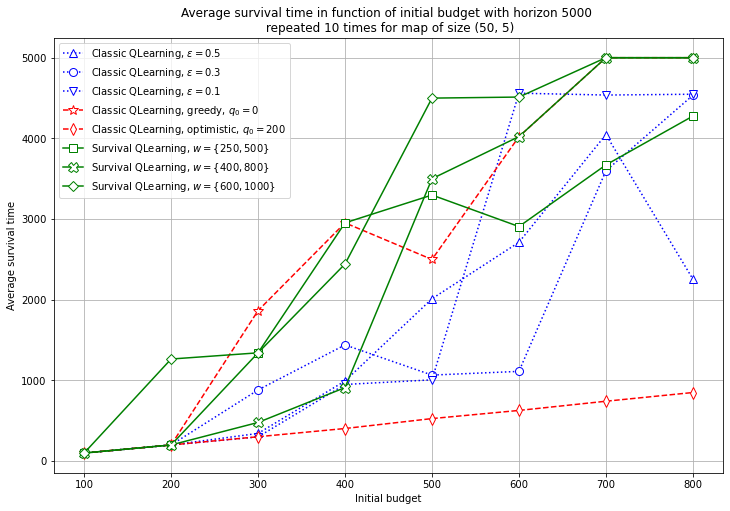

In [35]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, qclassic_5_time_mean, label=f"Classic QLearning, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_3_time_mean, label=f"Classic QLearning, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_1_time_mean, label=f"Classic QLearning, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_0_time_mean, label=f"Classic QLearning, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, qclassic_h_time_mean, label=f"Classic QLearning, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_250_time_mean, label="Survival QLearning, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_400_time_mean, label="Survival QLearning, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, qsurvival_600_time_mean, label="Survival QLearning, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Average survival time")
plt.legend()
plt.grid()
plt.title(f"Average survival time in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")  #and survival threshold [{survival_threshold}-{exploration_threshold}] 
plt.show()

### Alive rate

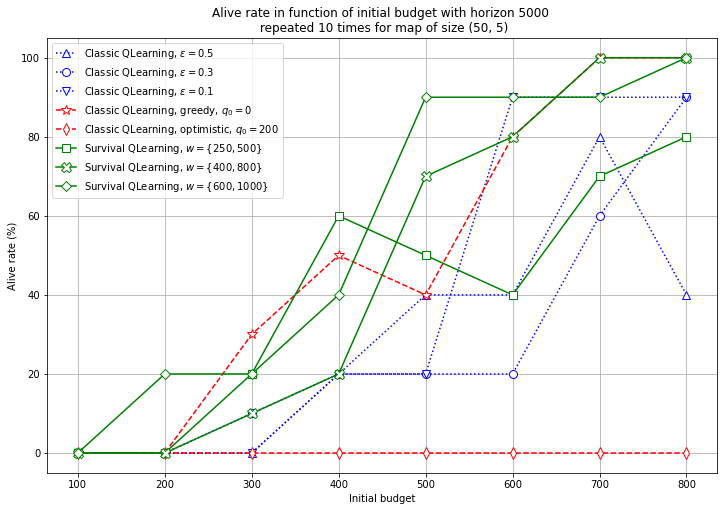

In [36]:
fig = plt.figure(figsize=(12, 8))
plt.plot(budgets, qclassic_5_alive_rate, label=f"Classic QLearning, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_3_alive_rate, label=f"Classic QLearning, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_1_alive_rate, label=f"Classic QLearning, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_0_alive_rate, label=f"Classic QLearning, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, qclassic_h_alive_rate, label=f"Classic QLearning, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_250_alive_rate, label="Survival QLearning, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_400_alive_rate, label="Survival QLearning, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, qsurvival_600_alive_rate, label="Survival QLearning, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Alive rate (%)")
plt.legend()
plt.grid()
plt.title(f"Alive rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Exploration rate

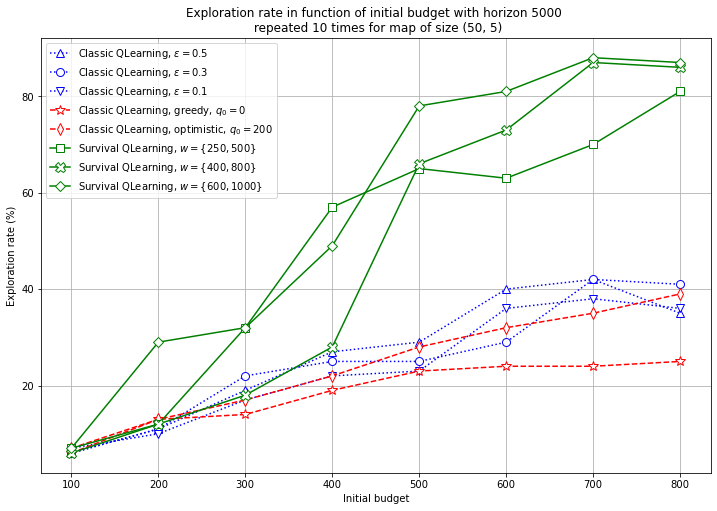

In [37]:
fig = plt.figure(figsize=(12, 8))
#plt.plot(budgets, cde_exploration_rate, label="CDELearning")
plt.plot(budgets, qclassic_5_exploration_rate, label=f"Classic QLearning, $\\varepsilon=0.5$", color='b', marker='^', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_3_exploration_rate, label=f"Classic QLearning, $\\varepsilon=0.3$", color='b', marker='o', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_1_exploration_rate, label=f"Classic QLearning, $\\varepsilon=0.1$", color='b', marker='v', markerfacecolor='w', markersize=8, ls=':')
plt.plot(budgets, qclassic_0_exploration_rate, label=f"Classic QLearning, greedy, $q_0=0$", color='r', ls='--', marker='*', markerfacecolor='w', markersize=10)
plt.plot(budgets, qclassic_h_exploration_rate, label=f"Classic QLearning, optimistic, $q_0=200$", color='r', ls='--', marker='d', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_250_exploration_rate, label="Survival QLearning, $w = \\{250, 500\\}$", color='g', ls='-', marker='s', markerfacecolor='w', markersize=8)
plt.plot(budgets, qsurvival_400_exploration_rate, label="Survival QLearning, $w = \\{400, 800\\}$", color='g', ls='-', marker='X', markerfacecolor='w', markersize=10)
plt.plot(budgets, qsurvival_600_exploration_rate, label="Survival QLearning, $w = \\{600, 1000\\}$", color='g', ls='-', marker='D', markerfacecolor='w', markersize=7)
plt.xlabel("Initial budget")
plt.ylabel("Exploration rate (%)")
plt.legend()
plt.grid()
plt.title(f"Exploration rate in function of initial budget with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

### Budget evolution

In [38]:
print("Available budgets :")
print(budgets)

#plt.rcParams["figure.figsize"] = (10,10)

with_bounds = False

show_only = [300, 400, 500]
colors = ['r', 'g', 'b']


Available budgets :
[100 200 300 400 500 600 700 800]


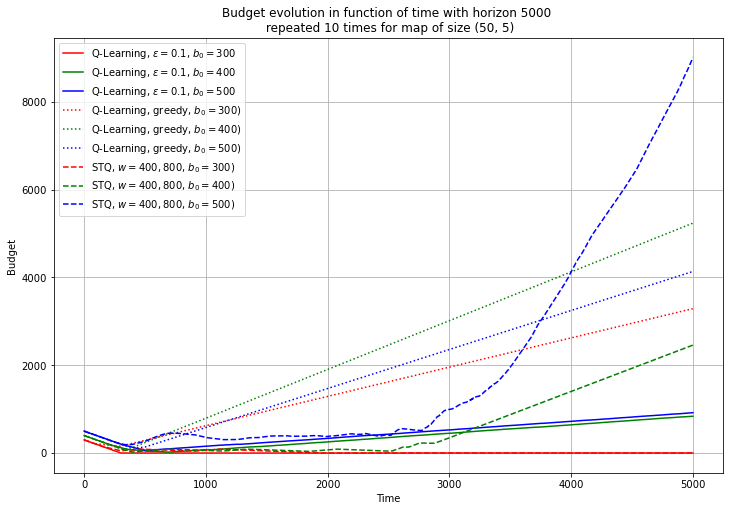

In [39]:
t = np.arange(horizon)

fig = plt.figure(figsize=(12, 8))

n=0
for i, evo in enumerate(qclassic_1_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, $\\varepsilon=0.1$, $b_0=${budgets[i]}", ls='-', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, qclassic_1_budget_evolutions_min[i], qclassic_1__budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

n=0
for i, evo in enumerate(qclassic_0_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"Q-Learning, greedy, $b_0=${budgets[i]})", ls=':', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, qclassic_0_budget_evolutions_min[i], qclassic_0_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)
            
n=0
for i, evo in enumerate(qsurvival_400_budget_evolutions_mean):
    if len(show_only) == 0 or budgets[i] in show_only:
        lines = plt.plot(t, evo, label=f"STQ, $w={{400, 800}}$, $b_0=${budgets[i]})", ls='--', color=colors[n])
        n += 1
        if with_bounds:
            plt.fill_between(t, qsurvival_400_budget_evolutions_min[i], qsurvival_400_budget_evolutions_max[i], color=lines[0].get_color(), alpha=0.15)

#plt.yscale('symlog')

#plt.plot(t, np.full((horizon,), survival_threshold), color="magenta", label=f"Survival threshold {survival_threshold}", ls="-.")
#plt.plot(t, 4.5 * t, color="lawngreen", ls="--", label=f"Budget optimal minor")
#plt.plot(t, 49.5 * t, color="turquoise", ls="--", label=f"Budget optimal major")
plt.xlabel("Time")
plt.ylabel("Budget")
plt.legend()
plt.grid()
plt.title(f"Budget evolution in function of time with horizon {horizon} \n repeated {repeat} times for map of size {map_size}")
plt.show()

## Success

### Classic QLearning

In [40]:
target_states = env.get_target_states()

target_means = dict()
for label, state in target_states.items():

    values = list()

    for j, b in enumerate(budgets):
        values.append(np.sum(qclassic_1_exploration_map[j][state, :]))

    target_means[label] = values

x = np.arange(len(budgets))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in target_means.items():
    offset = (width) * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of passages')
ax.set_title(f"Average number of passages through a positive reward \n as a function of budget for {repeat} repeat")
ax.set_xticks(x + 0.5 * width, budgets)
ax.legend(loc='upper left', ncols=3)
plt.show()

TypeError: __init__() got an unexpected keyword argument 'layout'

### Survival QLearning

In [ ]:
target_states = env.get_target_states()

target_means = dict()
for label, state in target_states.items():

    values = list()

    for j, b in enumerate(budgets):
        values.append(np.sum(qsurvival_400_exploration_map[j][state, :]))

    target_means[label] = values

x = np.arange(len(budgets))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in target_means.items():
    offset = (width) * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of passages')
ax.set_title(f"Average number of passages through a positive reward \n as a function of budget for {repeat} repeat")
ax.set_xticks(x + 0.5 * width, budgets)
ax.legend(loc='upper left', ncols=3)
plt.show()